### 2° peak search algorithm --- [source](https://williamsantos.me/posts/2023/spectrogram-peak-detection-with-scipy/#fn.3) ---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from librosa import load as load_audio, stft, amplitude_to_db
from librosa.display import specshow
from statistics import NormalDist
from scipy.ndimage import label as label_features
from scipy.ndimage import maximum_position as extract_region_maximums

In [ ]:
def peak_detection(file_path, threshold):
    y, _ = load_audio(path=file_path, sr=None)

    #do transformations
    x = stft(y)
    x = amplitude_to_db(abs(x))
    
    #remove zero values
    flattened = np.matrix.flatten(x)
    filtered = flattened[flattened > np.min(flattened)]
    print(flattened)
    print(filtered)

    #create a normal distribution from frequency intensities
    #then map a zscore onto each intensity value
    ndist = NormalDist(np.mean(filtered), np.std(filtered))
    print(ndist)
    zscore = np.vectorize(lambda x: ndist.zscore(x))
    zscore_matrix = zscore(x)

    #create label matrix from frequency intensities that are
    #above threshold
    mask_matrix = zscore_matrix > threshold
    labelled_matrix, num_regions = label_features(mask_matrix)
    label_indices = np.arange(num_regions) + 1

    #for each isolated region in the mask, identify the maximum
    #value, then extract it position
    peak_positions = extract_region_maximums(zscore_matrix, labelled_matrix, label_indices)

    #finally, create list of peaks (time, frequency, intensity)
    peaks = [[x, y] for y, x in peak_positions]

    _, ax = plt.subplots(figsize=(16, 8))

    ax.scatter(
        x=[p[0] for p in peaks],
        y=[p[1] for p in peaks],
        s=2,
        color="red"
    )
    ax.matshow(x)
    return peaks

[-42.73478  -34.826168 -19.675867 ... -53.803482 -53.803482 -53.803482]
[-42.73478  -34.826168 -19.675867 ... -53.057495 -46.644382 -48.135513]
NormalDist(mu=-29.27308464050293, sigma=17.64431381225586)
0


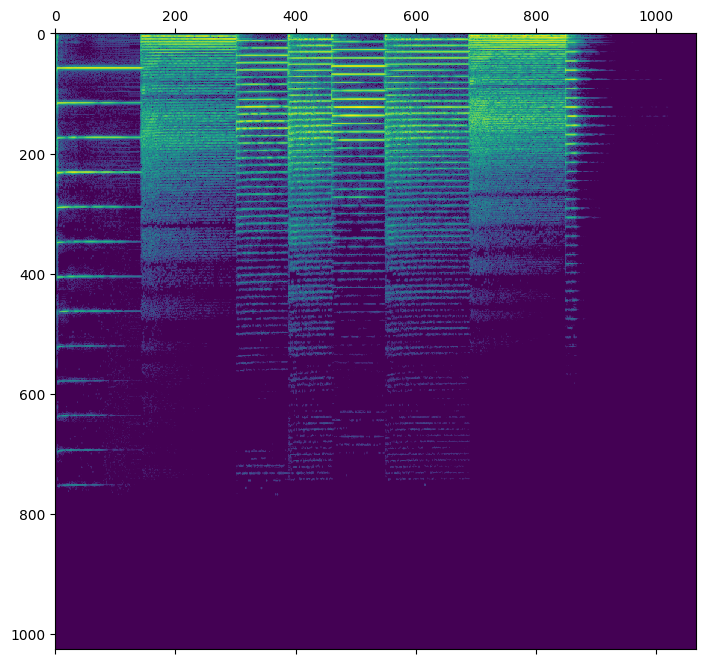

In [16]:
audio_file_path = "../dataset_creation/audios_low_ranges_w_clean/16_clean.mp3"
print(len(peak_detection(audio_file_path, 6)))


Base testing

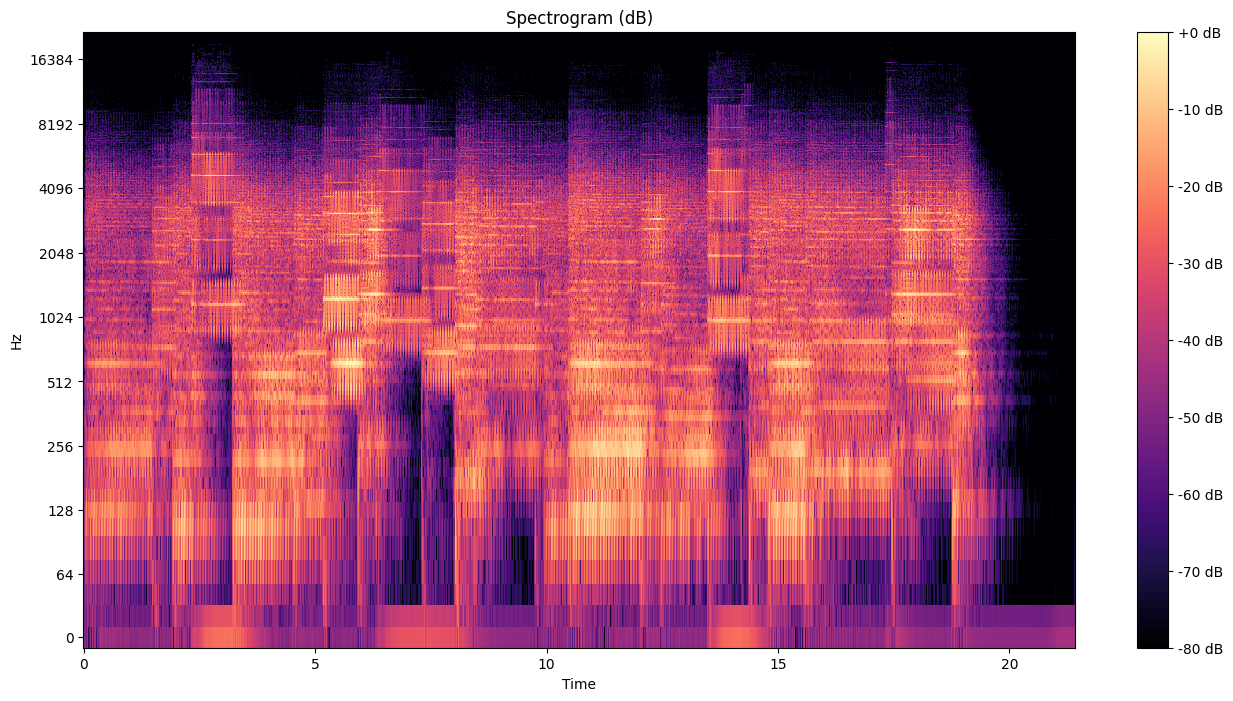

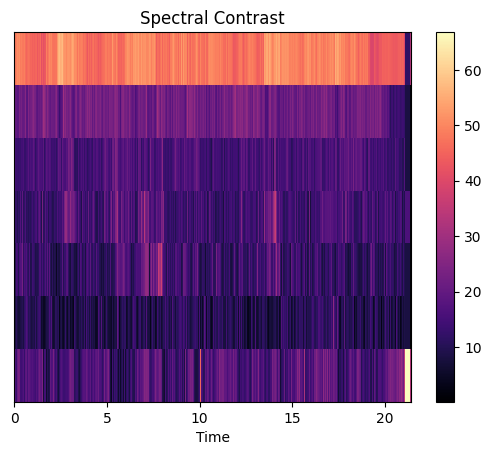

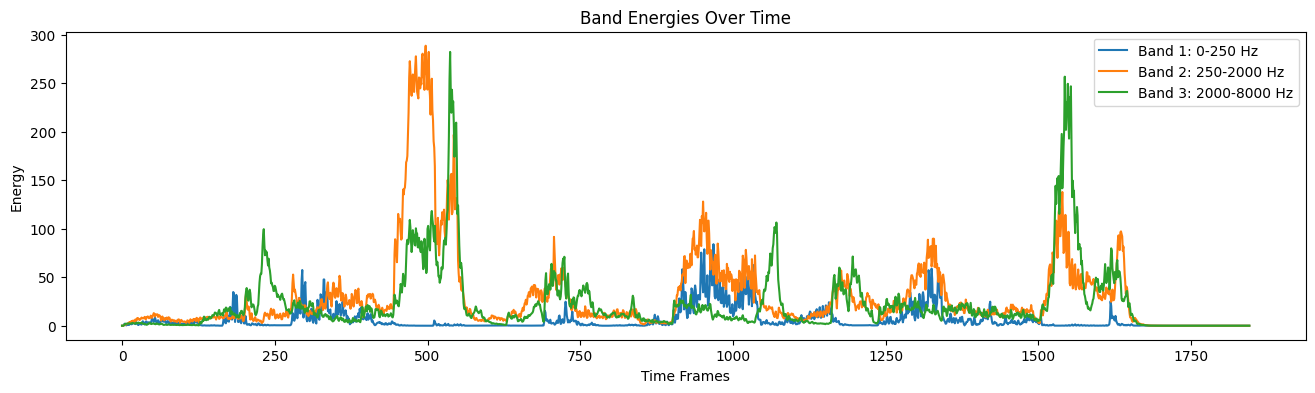

In [14]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio
file_path ="../dataset_creation/audios_low_ranges_w_clean/100.mp3"
y, sr = librosa.load(file_path, sr=None)

# Calculate the Short-Time Fourier Transform (STFT) to get the spectrogram
S = np.abs(librosa.stft(y))

# Convert amplitude spectrogram to decibel (dB) units for visualization
S_dB = librosa.amplitude_to_db(S, ref=np.max)

# Plot the spectrogram
fig, ax = plt.subplots(figsize=(16, 8))
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ax.set(title='Spectrogram (dB)')

# Calculate spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
fig, ax = plt.subplots()
img = librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Spectral Contrast')

# Calculate band energies
# Define frequency bands of interest (example: low, mid, high bands)
bands = [(0, 250), (250, 2000), (2000, 8000)]
band_energies = []

for band in bands:
    # Convert band frequencies to the index range in the spectrogram
    band_idx = np.where((librosa.fft_frequencies(sr=sr) >= band[0]) & 
                        (librosa.fft_frequencies(sr=sr) < band[1]))[0]
    # Sum energy within this band
    band_energy = np.sum(S[band_idx, :] ** 2, axis=0)
    band_energies.append(band_energy)

# Plot band energies
fig, ax = plt.subplots(figsize=(16, 4))
for i, energy in enumerate(band_energies):
    ax.plot(energy, label=f'Band {i+1}: {bands[i][0]}-{bands[i][1]} Hz')
ax.set(title='Band Energies Over Time', xlabel='Time Frames', ylabel='Energy')
ax.legend()
plt.show()
